# TEXT MINING AND SENTIIMENT ANALYSIS

In [2]:
# import relevant libraries
import re
import nltk
import requests
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.probability import FreqDist
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

# set random state
random_seed = 234

## WEB SCRAPING

The data was scraped from `https://www.airlinequality.com/airline-reviews/british-airways` to get customer reviews on the British Airways Airline.

In [2]:
"""
review_date, country, rating, review = [], [], [], []
# Number of pages to scrape
pages = 300
# iterate through the first 300 pages
for page in range(1, pages+1):
    url = f'https://www.airlinequality.com/airline-reviews/british-airways/page/{page}/'
    response = requests.get(url).content
    # create soup object
    soup = BeautifulSoup(response, 'html.parser')

    # get the articles
    articles = soup.find(name='article', attrs={'class': 'comp comp_reviews-airline querylist position-content'})
    # Iterate through each article and append review_date, country, rating, and review
    for article in articles.find_all(name='article'):
        # add review date
        review_date.append(article.find(name='time', itemprop='datePublished').string)
        # add rating
        rating.append(article.find(name='span', itemprop='ratingValue').string)
        # Use regular expressions to find the country enclosed in brackets
        if match:= re.search(r'.*\((.*)\).*', article.find('h3').text):
            country.append(match.group(1))
        # add review
        review.append(article.find('div', class_='text_content').text)

    # Just to show progress of the reviews scraped
    if page in (np.linspace(1, pages+1, 11) - 1):
        print(f'Scraped {len(review_date)} total reviews')
        print('...', end='\n')
        
    
print(f'Scraped {len(review_date)} reviews successfully') 

# combine the lists into a dict
data = {'review_date': review_date, 'country': country, 'rating': rating, 'review': review}

# Create a df from data
df = pd.DataFrame(data=data)

# save the dataframe to a csv
df.to_csv('British_Airways_Reviews.csv')
"""

"\nreview_date, country, rating, review = [], [], [], []\n# Number of pages to scrape\npages = 300\n# iterate through the first 300 pages\nfor page in range(1, pages+1):\n    url = f'https://www.airlinequality.com/airline-reviews/british-airways/page/{page}/'\n    response = requests.get(url).content\n    # create soup object\n    soup = BeautifulSoup(response, 'html.parser')\n\n    # get the articles\n    articles = soup.find(name='article', attrs={'class': 'comp comp_reviews-airline querylist position-content'})\n    # Iterate through each article and append review_date, country, rating, and review\n    for article in articles.find_all(name='article'):\n        # add review date\n        review_date.append(article.find(name='time', itemprop='datePublished').string)\n        # add rating\n        rating.append(article.find(name='span', itemprop='ratingValue').string)\n        # Use regular expressions to find the country enclosed in brackets\n        if match:= re.search(r'.*\\((.*)\\

## Data loading and exploration

In [3]:
# load the data
df = pd.read_csv('data/British_Airways_Reviews.csv', index_col=0)
df.head()

,review_date,country,rating,review
0,18th November 2024,United States,1,Not Verified | British Airways stranding my w...
1,17th November 2024,United Kingdom,4,✅ Trip Verified | Although like many these d...
2,15th November 2024,United Kingdom,10,✅ Trip Verified | This flight was British Airw...
3,13th November 2024,Australia,1,Not Verified | The worst airline I have ever f...
4,8th November 2024,Iceland,3,"✅ Trip Verified | Disappointing service, pla..."


In [4]:
# remove unnecessary text from each of the rows; ("✅ Trip Verified |", 
#✅ Verified Review | and "Not Verified |"), then strip the whitespaces
df['review'] = df['review'].str.replace(r'^Not Verified \||^✅ Trip Verified \||✅ Verified Review \|',
                                        '', regex=True).str.strip()
df.head()

,review_date,country,rating,review
0,18th November 2024,United States,1,British Airways stranding my wife and I at Hea...
1,17th November 2024,United Kingdom,4,"Although like many these days, I avoid BA on l..."
2,15th November 2024,United Kingdom,10,This flight was British Airways at its very be...
3,13th November 2024,Australia,1,The worst airline I have ever flown with. They...
4,8th November 2024,Iceland,3,"Disappointing service, plane interior and terr..."


In [5]:
df.shape

(3000, 4)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 0 to 2999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_date  3000 non-null   object
 1   country      3000 non-null   object
 2   rating       3000 non-null   int64 
 3   review       3000 non-null   object
dtypes: int64(1), object(3)
memory usage: 117.2+ KB


In [7]:
# check for missing values
df.isna().sum()

review_date    0
country        0
rating         0
review         0
dtype: int64

In [8]:
# check for duplicates
df.duplicated().sum()

0

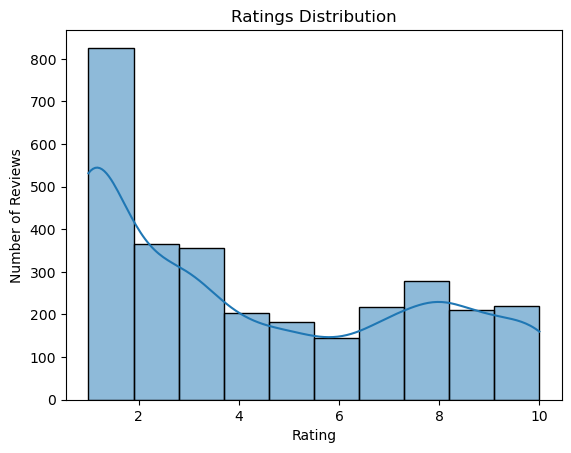

In [9]:
# Create histograms to visualize the distributions of the ratings
sns.histplot(data=df, kde=True, x='rating', bins=10)
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")
plt.title("Ratings Distribution")
plt.show()

In [10]:
# Define bins for rating categories
bins = [1, 3, 7, 10]
labels = ['Bad', 'Average', 'Good']

# Create a new column 'rating_category' using pd.cut
df['rating_category'] = pd.cut(df['rating'], bins=bins, labels=labels, include_lowest=True)

df.sample(7)

,review_date,country,rating,review,rating_category
464,9th December 2022,Czech Republic,3,"I flew from Prague to LHR. Excellent service, ...",Bad
666,23rd December 2021,United Arab Emirates,2,I had low expectations of business class BA on...,Bad
2464,18th May 2016,United Kingdom,2,"British Airways from Gatwick to Catania, Sicil...",Bad
2182,21st November 2016,United Kingdom,9,Flew British Airways from London to Baltimore....,Good
735,30th May 2021,United Kingdom,9,After sixteen months of being grounded by COVI...,Good
1242,16th November 2018,United States,8,London to Boston. I was seated next to a custo...,Good
261,28th August 2023,United Kingdom,1,"Filthy plane, cabin staff ok, appalling custom...",Bad


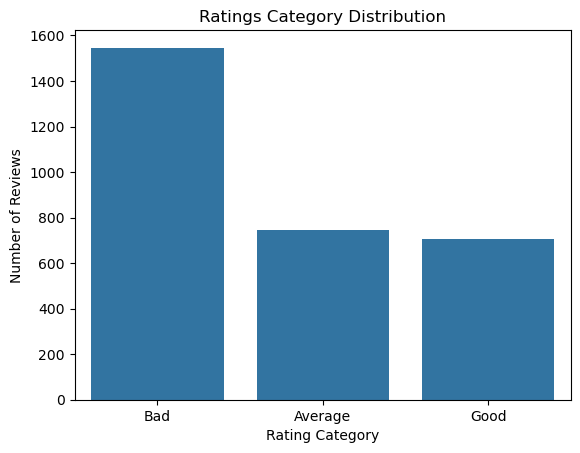

In [11]:
# view the distrubtion of the rating categories
sns.countplot(data=df, x='rating_category')
plt.xlabel("Rating Category")
plt.ylabel("Number of Reviews")
plt.title("Ratings Category Distribution")
plt.show()

In [12]:
# Display sample reviews
print("Sample Bad rating Review:", df[df['rating_category'] == "Bad"]['review'].iloc[0], '\n')

print("Sample Average rating Review:", df[df['rating_category'] == "Average"]['review'].iloc[0], '\n')

print("Sample Good rating Review:", df[df['rating_category'] == "Good"]['review'].iloc[0])


Sample Bad rating Review: British Airways stranding my wife and I at Heathrow Airport for 2.5 days, with no access to our baggage. We we told by airline employees to purchase any necessities (toiletries, refreshments, etc.) and we'd be reimbursed. That claim was denied, with BA claiming that weather was the reason for the delay (an outright lie since every other airline in London was flying on-time). We were unable to to anything besides stand in lines for vouchers, stand in lines for shuttles, stand in line for reservations, etc. for 48+ hours. It was an absolute nightmare and I will never fly BA again. 

Sample Average rating Review: Although like many these days, I avoid BA on long haul from London Heathrow due to my perception of poor service and lack of customer services if things go wrong, I was pleasantly surprised by my recent flight to Belfast. The aircraft actually left on time and arrived ahead of schedule. The cabin crew looked bored and uninspired as they can often do on B

## PREPROCESSING

In [13]:
# define stopwords
stop_words = nltk.corpus.stopwords.words('english')

# Create preprocessing function
def preprocessor(review):
    # Tokenize the words by picking only the letters and numbers and '
    tokenizer = nltk.tokenize.RegexpTokenizer('[a-zA-Z0-9\']+')
    tokenized_reviews = tokenizer.tokenize(review)
    
    # change to lowercase and remove stopwords
    cleaned_reviews = [word.lower() for word in tokenized_reviews if word.lower() not in stop_words]
    
    # Stem the words to their root forms
    stemmer = nltk.stem.PorterStemmer()
    stemmed_reviews = [stemmer.stem(word) for word in cleaned_reviews]
    
    return " ".join(stemmed_reviews)

In [14]:
# Apply the preprecessing function
df['review_preprocessed'] = df['review'].apply(preprocessor)
df.head()

,review_date,country,rating,review,rating_category,review_preprocessed
0,18th November 2024,United States,1,British Airways stranding my wife and I at Hea...,Bad,british airway strand wife heathrow airport 2 ...
1,17th November 2024,United Kingdom,4,"Although like many these days, I avoid BA on l...",Average,although like mani day avoid ba long haul lond...
2,15th November 2024,United Kingdom,10,This flight was British Airways at its very be...,Good,flight british airway best flight attend outst...
3,13th November 2024,Australia,1,The worst airline I have ever flown with. They...,Bad,worst airlin ever flown cancel flight 3 hour d...
4,8th November 2024,Iceland,3,"Disappointing service, plane interior and terr...",Bad,disappoint servic plane interior terribl incom...


In [15]:
# separate into feature and target variables
X = df['review_preprocessed']
y = df['rating_category']

In [16]:
df['rating_category'].unique()

['Bad', 'Average', 'Good']
Categories (3, object): ['Bad' < 'Average' < 'Good']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed, stratify=y)
X_train.shape, X_test.shape

((2400,), (600,))

### Vectorizing

In [18]:
# Apply CountVectorizer
vect = CountVectorizer()
X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2400, 8242), (600, 8242), (2400,), (600,))

In [19]:
pd.DataFrame(X_train.toarray()).head()

,0,1,2,3,4,5,6,7,8,9,...,8232,8233,8234,8235,8236,8237,8238,8239,8240,8241
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### SAMPLING

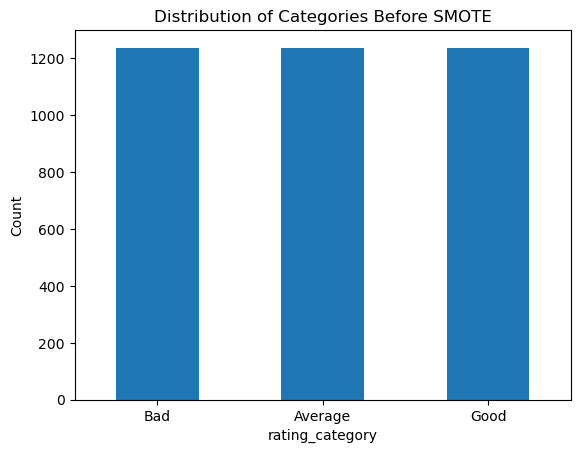

In [31]:
# before sampling
y_train.value_counts().plot(kind='bar')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.title('Distribution of Categories Before SMOTE')
plt.show()

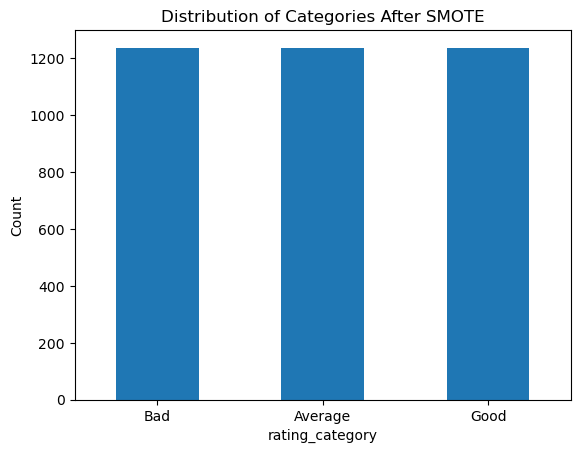

In [30]:
# apply SMOTE
sampler = SMOTE(random_state=random_seed)
X_train, y_train = sampler.fit_resample(X_train, y_train)
# After sampling
y_train.value_counts().plot(kind='bar')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.title('Distribution of Categories After SMOTE')
plt.show()

## Text Classification

In [22]:
bayes = MultinomialNB()
bayes.fit(X_train, y_train)
y_pred_bayes = bayes.predict(X_test)

In [23]:
print(classification_report(y_test, y_pred_bayes))

              precision    recall  f1-score   support

     Average       0.48      0.59      0.53       149
         Bad       0.84      0.77      0.80       309
        Good       0.73      0.69      0.71       142

    accuracy                           0.71       600
   macro avg       0.68      0.68      0.68       600
weighted avg       0.73      0.71      0.71       600



"Bad" Reviews (Majority Class): High precision (0.84) and recall (0.77) and F1-score (0.80). This indicates the model effectively identifies "Bad" reviews with minimal false positives.

"Good" Reviews (Minority Class): Reasonable F1-score (0.71), but slightly lower recall (0.69), suggesting the model misses some "Good" reviews.

"Average" Reviews: Lower precision (0.48) and F1-score (0.53) show that this class is the most challenging to classify due to possible overlap in sentiments.

In [24]:
# get weighted metrics
f1 = round(f1_score(y_test, y_pred_bayes, average='weighted'), 2)
precision = round(precision_score(y_test, y_pred_bayes, average='weighted'), 2)
recall = round(recall_score(y_test, y_pred_bayes, average='weighted'), 2)
accuracy = round(accuracy_score(y_test, y_pred_bayes), 2)

print(f"""Weighted F1 score = {f1}
Weighted Precison = {precision}
Weighted Recall = {recall}
Accuracy = {accuracy}""")

Weighted F1 score = 0.71
Weighted Precison = 0.73
Weighted Recall = 0.71
Accuracy = 0.71


In [25]:
matrix = confusion_matrix(y_test, y_pred_bayes)
matrix

array([[ 88,  27,  34],
       [ 69, 238,   2],
       [ 26,  18,  98]], dtype=int64)

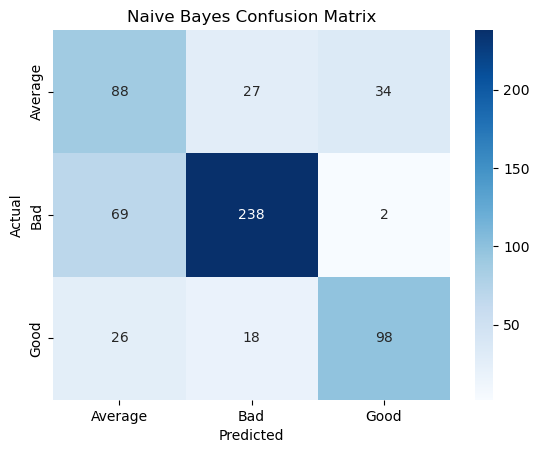

In [26]:
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Average', 'Bad', 'Good'], yticklabels=['Average', 'Bad', 'Good'])
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Sentiment Analysis

In [27]:
sentiment = SentimentIntensityAnalyzer()

In [28]:
# Get the polarity scores for each review in the review column
df['negative'] = [sentiment.polarity_scores(rev)['neg'] for rev in df['review']]
df['neutral'] = [sentiment.polarity_scores(rev)['neu'] for rev in df['review']]
df['positive'] = [sentiment.polarity_scores(rev)['pos'] for rev in df['review']]
df['compound'] = [sentiment.polarity_scores(rev)['compound'] for rev in df['review']]
df[['rating_category', 'review_preprocessed', 'negative', 'neutral', 'positive', 'compound']].head()

,rating_category,review_preprocessed,negative,neutral,positive,compound
0,Bad,british airway strand wife heathrow airport 2 ...,0.072,0.928,0.000,-0.7506
1,Average,although like mani day avoid ba long haul lond...,0.119,0.814,0.066,-0.6663
2,Good,flight british airway best flight attend outst...,0.000,0.552,0.448,0.9838
3,Bad,worst airlin ever flown cancel flight 3 hour d...,0.111,0.889,0.000,-0.9081
4,Bad,disappoint servic plane interior terribl incom...,0.108,0.860,0.032,-0.9848


In [29]:
# create a function to classify the sentiments based on compound score
def classify_sentiment(compound):
    if compound > 0.05:
        return 'Positive'
    elif compound < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Creat a sentiment column that classifies the reviews
df['Sentiment'] = df['compound'].apply(classify_sentiment)
df[['review_preprocessed', 'negative', 'neutral', 'positive', 'compound', 'Sentiment']].head()

,review_preprocessed,negative,neutral,positive,compound,Sentiment
0,british airway strand wife heathrow airport 2 ...,0.072,0.928,0.000,-0.7506,Negative
1,although like mani day avoid ba long haul lond...,0.119,0.814,0.066,-0.6663,Negative
2,flight british airway best flight attend outst...,0.000,0.552,0.448,0.9838,Positive
3,worst airlin ever flown cancel flight 3 hour d...,0.111,0.889,0.000,-0.9081,Negative
4,disappoint servic plane interior terribl incom...,0.108,0.860,0.032,-0.9848,Negative


### SENTIMENT EDA

In [32]:
df[['negative', 'neutral', 'positive', 'compound']].describe()

,negative,neutral,positive,compound
count,3000.000000,3000.000000,3000.000000,3000.000000
mean,0.082646,0.812139,0.105216,0.095243
std,0.055450,0.072651,0.079674,0.786217
min,0.000000,0.436000,0.000000,-0.997400
25%,0.043000,0.769000,0.048000,-0.778600
50%,0.075000,0.818000,0.087500,0.273200
75%,0.113000,0.863000,0.145000,0.911725
max,0.348000,1.000000,0.490000,0.999200


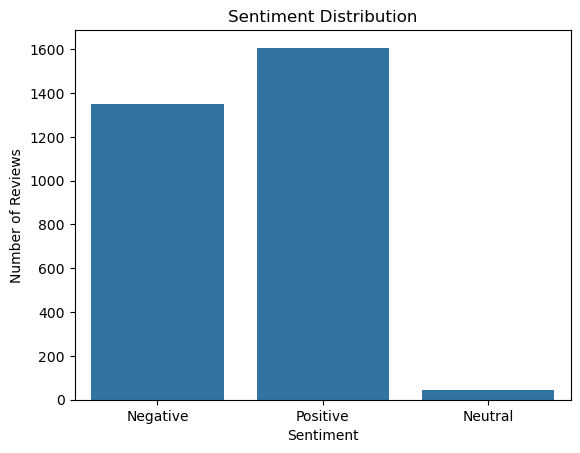

In [33]:
# check the distribution of sentment
sns.countplot(data=df, x='Sentiment')
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.title("Sentiment Distribution")
plt.show()

In [63]:
df['Sentiment'].value_counts(normalize=True)

Sentiment
Positive    0.535667
Negative    0.449667
Neutral     0.014667
Name: proportion, dtype: float64

The majority of reviews are Positive, followed by a significant number of Negative reviews.
Neutral reviews are minimal, suggesting that most customers express clear opinions (either positive or negative) rather than balanced or neutral sentiments.

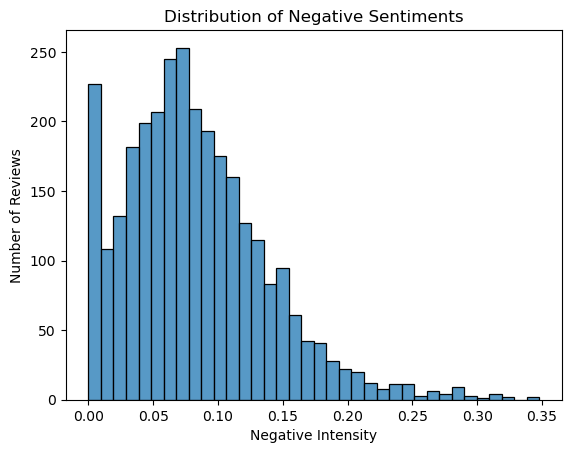

In [34]:
# check the distribution of negative scores
sns.histplot(data=df, x='negative')
plt.xlabel("Negative Intensity")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Negative Sentiments")
plt.show()

Most reviews classified as Negative have lower intensity (scores closer to 0.05), meaning they are weakly negative, indicating that strongly negative reviews are less common.

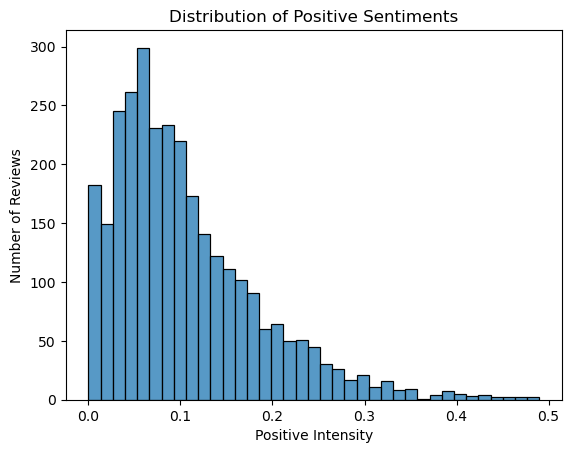

In [35]:
# check the distribution of positve scores
sns.histplot(data=df, x='positive')
plt.xlabel("Positive Intensity")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Positive Sentiments")
plt.show()

Similar to negative sentiments, the majority of Positive reviews have lower intensity scores (closer to 0.1).
Strongly positive reviews (higher sentiment scores) are less frequent.

### Seniment Across Country Groups

In [36]:
# check the number of reviews for each country
df['country'].value_counts()

country
United Kingdom           1842
United States             373
Canada                    101
Australia                  99
Germany                    63
                         ... 
Jordan                      1
Senegal                     1
Vietnam                     1
Saint Kitts and Nevis       1
Panama                      1
Name: count, Length: 71, dtype: int64

UK has more than half of the reviews, so we divide the groups into UK and Rest of the World

In [37]:
# create a country group that categorizes the countries as 'UK' against the 'rest of the world'
df['Country_Groups'] = df['country'].apply(lambda x: 'United Kingdom' 
                                           if x == 'United Kingdom' else 'Rest of the World')

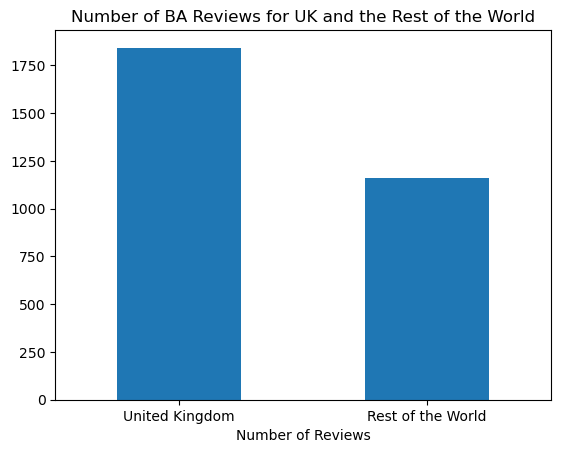

In [38]:
df['Country_Groups'].value_counts().plot(kind='bar')
plt.xlabel('Number of Reviews')
plt.xticks(rotation=0)
plt.title("Number of BA Reviews for UK and the Rest of the World")
plt.show()

In [39]:
# see how many negative reviews for each group
negative_reviews = df[df['Sentiment'] == 'Negative']['Country_Groups'].value_counts()
negative_reviews

Country_Groups
United Kingdom       805
Rest of the World    544
Name: count, dtype: int64

In [40]:
# Total revieww for each group
total_reviews = df['Country_Groups'].value_counts()
total_reviews

Country_Groups
United Kingdom       1842
Rest of the World    1158
Name: count, dtype: int64

In [41]:
# Calculate the percentage of negative reviews in each group
negative_percentage = negative_reviews / total_reviews * 100
negative_percentage

Country_Groups
United Kingdom       43.702497
Rest of the World    46.977547
Name: count, dtype: float64

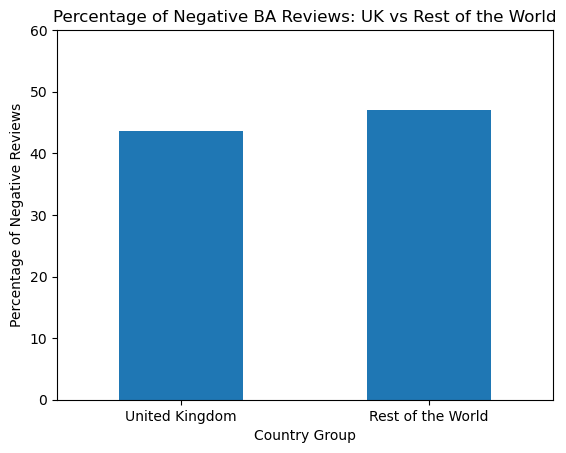

In [42]:
# Plot the negative review percentages
negative_percentage.plot(kind='bar')
plt.xlabel("Country Group")
plt.ylabel("Percentage of Negative Reviews")
plt.xticks(rotation=0)
plt.ylim(0,60)
plt.title("Percentage of Negative BA Reviews: UK vs Rest of the World")
plt.show()

The percentage of negative reviews is slightly higher for the Rest of the World compared to the UK, suggesting that international customers may have more complaints or negative experiences.

The difference isn’t drastic, which indicates that dissatisfaction is fairly widespread and not isolated to one geographic group.

### Sentime Over Time

In [43]:
# Get the review years
df['Review_Year'] = df['review_date'].str[-4:]
df['Review_Year'] = df['Review_Year'].astype('int')
df.head()

,review_date,country,rating,review,rating_category,review_preprocessed,negative,neutral,positive,compound,Sentiment,Country_Groups,Review_Year
0,18th November 2024,United States,1,British Airways stranding my wife and I at Hea...,Bad,british airway strand wife heathrow airport 2 ...,0.072,0.928,0.000,-0.7506,Negative,Rest of the World,2024
1,17th November 2024,United Kingdom,4,"Although like many these days, I avoid BA on l...",Average,although like mani day avoid ba long haul lond...,0.119,0.814,0.066,-0.6663,Negative,United Kingdom,2024
2,15th November 2024,United Kingdom,10,This flight was British Airways at its very be...,Good,flight british airway best flight attend outst...,0.000,0.552,0.448,0.9838,Positive,United Kingdom,2024
3,13th November 2024,Australia,1,The worst airline I have ever flown with. They...,Bad,worst airlin ever flown cancel flight 3 hour d...,0.111,0.889,0.000,-0.9081,Negative,Rest of the World,2024
4,8th November 2024,Iceland,3,"Disappointing service, plane interior and terr...",Bad,disappoint servic plane interior terribl incom...,0.108,0.860,0.032,-0.9848,Negative,Rest of the World,2024


In [44]:
# calculate the average sentiment by year
yearly_sentiment = df.groupby('Review_Year')['compound'].mean()
yearly_sentiment

Review_Year
2015    0.198250
2016    0.228358
2017    0.048171
2018    0.144835
2019    0.149304
2020    0.075421
2021    0.017640
2022    0.036164
2023   -0.139856
2024   -0.088722
Name: compound, dtype: float64

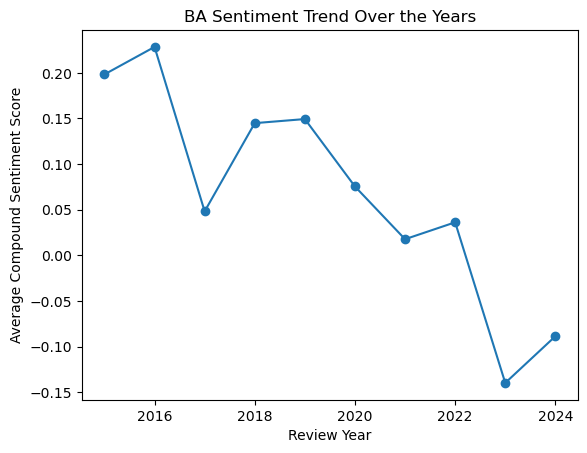

In [45]:
# Plot sentiment trends over years
yearly_sentiment.plot(kind='line', marker='o')
plt.xlabel("Review Year")
plt.ylabel("Average Compound Sentiment Score")
plt.title("BA Sentiment Trend Over the Years")
plt.show()

The average sentiment score for British Airways reviews has declined over time, reaching negative values in recent years. 

This trend indicates increasing customer dissatisfaction, especially after 2022.

The slight recovery in 2024 suggests possible efforts to improve customer satisfaction, but it’s still lower compared to earlier years like 2015-2017.

## Wordclouds

### Positive Wordcloud

In [55]:
# add uninformative word to the stopwords
uninformative_words = ['fly', 'flight', 'british', 'airways', 'ba', 'airline', 'plane', 
                       'aircraft', 'really', 'one', 'told', 'would', 'could', 'get']
stop_words = stop_words + uninformative_words

# Create preprocessing function
def preprocessor_informative(review):
    # Tokenize the words by picking only the letters and numbers and '
    tokenizer = nltk.tokenize.RegexpTokenizer('[a-zA-Z0-9\']+')
    tokenized_reviews = tokenizer.tokenize(review)
    
    # change to lowercase and remove stopwords
    cleaned_reviews = [word.lower() for word in tokenized_reviews if word.lower() not in stop_words]
    
    # Stem the words to their root forms
    stemmer = nltk.stem.PorterStemmer()
    stemmed_reviews = [stemmer.stem(word) for word in cleaned_reviews]
    
    return " ".join(stemmed_reviews)

# apply the new preprocessing to show only important words
df['review_informative'] = df['review'].apply(preprocessor_informative)

In [56]:
# Get all the positive tokens Wordcloud
positive_reviews = ' '.join(df[df['Sentiment'] == 'Positive']['review_informative'])

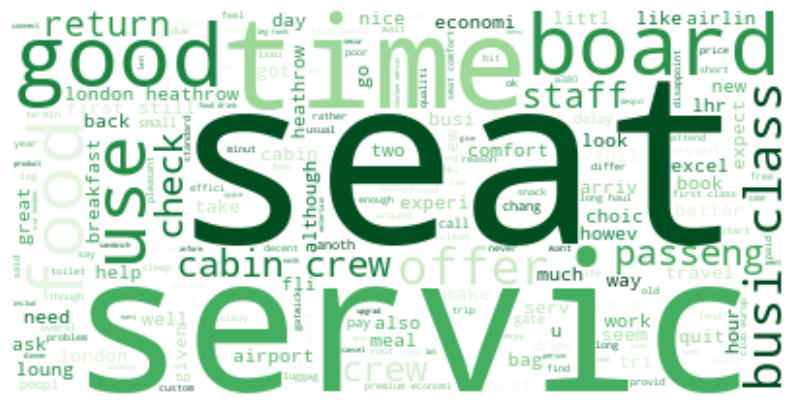

In [58]:
plt.figure(figsize=(10,7))
postive_wordcloud = WordCloud(background_color='white', max_words=300, stopwords=stop_words, 
                              random_state=random_seed, colormap='Greens').generate(positive_reviews)

plt.imshow(postive_wordcloud, interpolation='bilinear')
plt.axis('off')
#postive_wordcloud.to_file('positive_wordcloud.png')
plt.show()

### Negative Wordcloud

In [59]:
# Get all the negative tokens 
negative_reviews = ' '.join(df[df['Sentiment'] == 'Negative']['review_informative'])

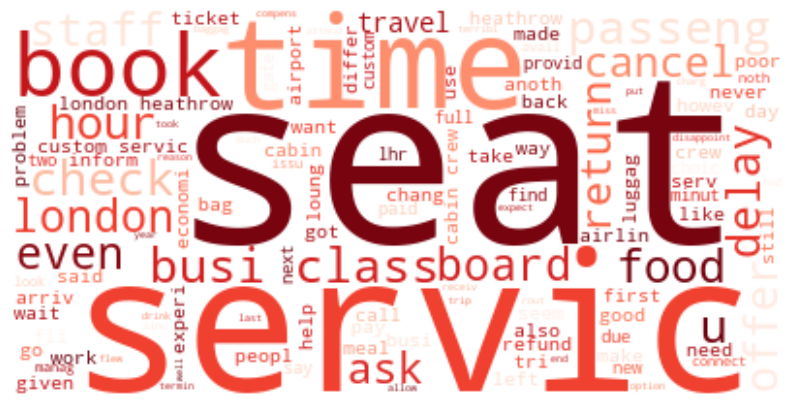

In [60]:
plt.figure(figsize=(10,7))
negative_wordcloud = WordCloud(background_color='white', max_words=300, stopwords=stop_words, 
                               random_state=random_seed, colormap='Reds').generate(negative_reviews)

plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
#negative_wordcloud.to_file('negative_wordcloud.png')
plt.show()

### Frequency Distribution

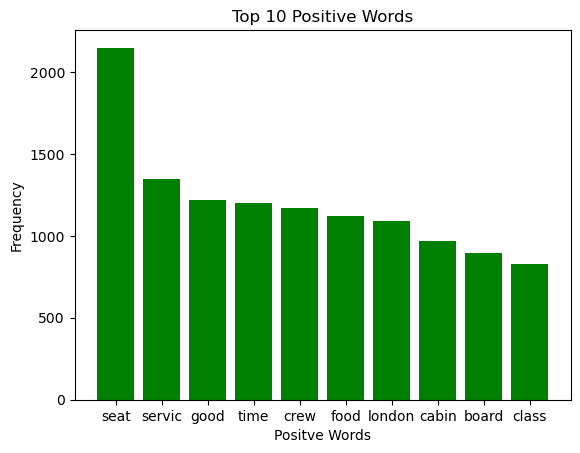

In [61]:
positive_freq = FreqDist(positive_reviews.split())
# get the 10 most common words
most_common = positive_freq.most_common(10)
words, frequency = zip(*most_common)

# Plot the top 10 most common positve words
plt.bar(words, frequency, color='green')
plt.xlabel("Positve Words")
plt.ylabel("Frequency")
plt.title("Top 10 Positive Words")
plt.show()

Dominated by terms like "service", "good", "crew", "food", and "time".

These words reflect aspects of customer satisfaction such as excellent service, timely flights, and positive interactions with the crew.

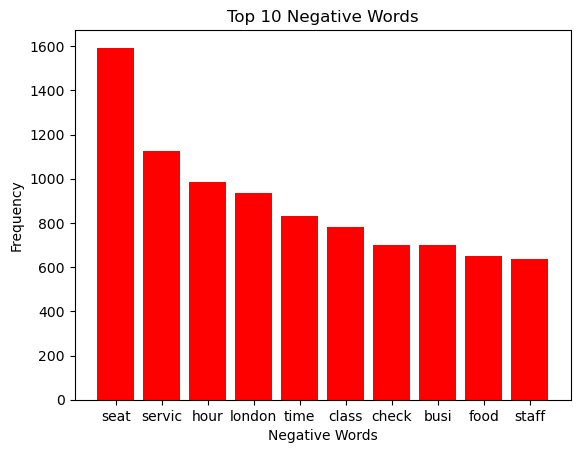

In [62]:
negative_freq = FreqDist(negative_reviews.split())
# get the 10 most common words
most_common = negative_freq.most_common(10)
words, frequency = zip(*most_common)

# Plot the top 10 most common positve words
plt.bar(words, frequency, color='red')
plt.xlabel("Negative Words")
plt.ylabel("Frequency")
plt.title("Top 10 Negative Words")
plt.show()

Frequent words include "service", "London", "time", "seat", and "check".

Negative contexts highlight complaints about service quality, delays, seat comfort, and issues with processes like check-ins or upgrades.

### Correlation Analysis

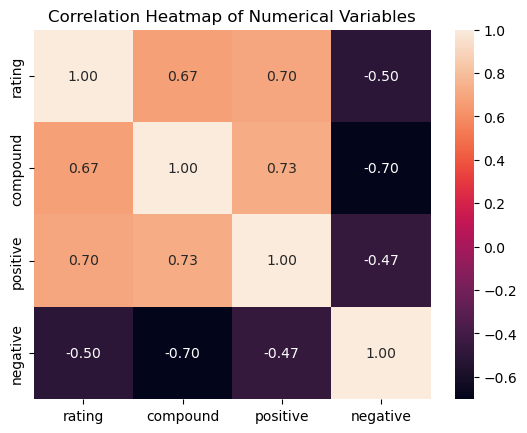

In [32]:
# Plot the correllation between all the numeric variables
numerical_columns = ['rating', 'compound', 'positive', 'negative']

# Calculate the correlation matrix
corr_matrix = df[numerical_columns].corr()

# plot the heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.title("Correlation Heatmap of Numerical Variables")
plt.show()